<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Ripples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'Get Standard Modules'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
from google.colab import files


warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)
clear_output(wait=False)



!pip install openpyxl
!pip install XlsxWriter
!pip install --upgrade pyabf
import pyabf

'''Get Repositories'''
try: shutil.rmtree('/content/EphysLib')
except: None




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 2.8 MB/s eta 0:00:00


In [ ]:
def get_drobox_folder(link, new_filename):
    'Download a folder from dropbox and unzip'
    zipped_file_path = "/content/"+new_filename + ".zip"
    unzipped_file_path = "/content/"+new_filename
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    # if not( os.path.exists(new_filename_stripped)):
    !echo A | unzip $zipped_file_path -d $unzipped_file_path
    return new_filename

In [ ]:
def z_trans_2(x):
    x_mean = np.expand_dims(np.mean(x,axis=1),1)
    x_std = np.expand_dims(np.std(x,axis=1),1)
    x_z = (x - x_mean) / x_std
    return x_z

def z_trans(x):
    x_mean = np.mean(x)
    x_std = np.std(x)
    x_z = (x - x_mean) / x_std
    return x_z

def mov_mean(x,stride):
    x_mm = np.convolve(x,np.ones(stride),'same')/stride
    return x_mm

In [ ]:
data_source = "https://www.dropbox.com/sh/03361h631eiyi03/AAANIvLRFaTcsbMoD_FsUS7_a?dl=0"
data_name = 'Bumet'

file_loc = get_drobox_folder(data_source, data_name +'_ephys_data')

--2023-07-10 22:14:45--  https://www.dropbox.com/sh/03361h631eiyi03/AAANIvLRFaTcsbMoD_FsUS7_a?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/03361h631eiyi03/AAANIvLRFaTcsbMoD_FsUS7_a [following]
--2023-07-10 22:14:45--  https://www.dropbox.com/sh/raw/03361h631eiyi03/AAANIvLRFaTcsbMoD_FsUS7_a
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdaea00d9ccde398046abb2ba64.dl.dropboxusercontent.com/zip_download_get/BjD-eAoghEcYuGcJ4AFcK4Dethz9VE1LE3Of4JdEZnqOoGqmpbl8J4oMuTzdUfLLjZmWwHMO9HgIr6jJpWNYwLF49bqsal9RJeGN6vQmHhqulw# [following]
--2023-07-10 22:14:46--  https://ucdaea00d9ccde398046abb2ba64.dl.dropboxusercontent.com/zip_download_get/BjD-eAoghEcYuGcJ4AFcK4Dethz9VE1LE3Of4JdEZnqOoGqmpbl8J4oMuTzdUfLLjZmWwHMO9HgIr6jJpWNYwLF49bqs

5000
196


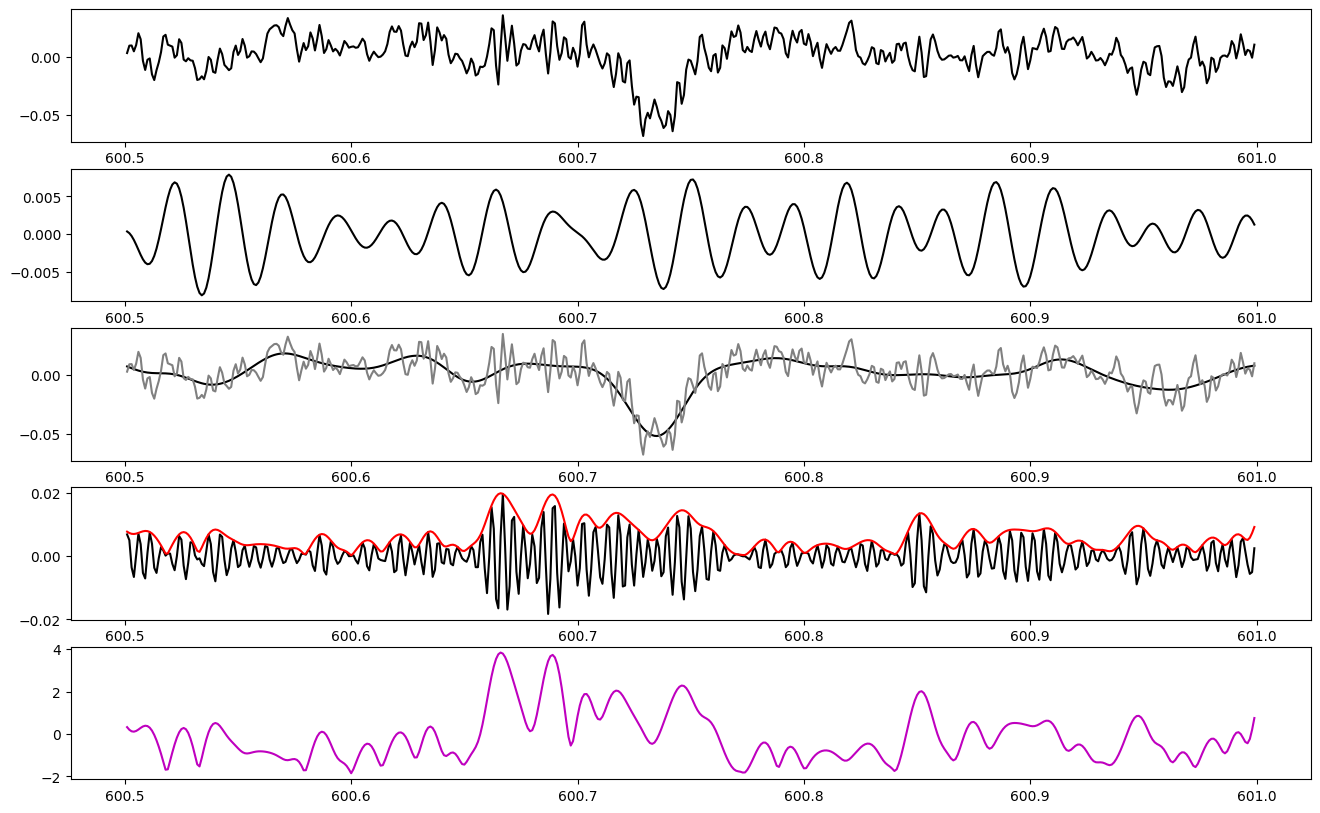

In [ ]:
#### Gillespie et al Method
abf = pyabf.ABF('/content/Bumet_ephys_data/2023x07x06_E3KI_F_P525_s3x4_0000.abf')



fs = abf.sampleRate
print(fs)
abf.setSweep(sweepNumber=0,channel=0)
v_trace = abf.sweepY
time = abf.sweepX

ds_factor = np.ceil(fs/1000)
v_trace_1khz = v_trace[::int(ds_factor)]
time_1khz = time[::int(ds_factor)]
fs = 1000

order = 4

b, a = scipy.signal.butter(order, [0.7,300], btype='bandpass',fs=fs)
narrow_band = scipy.signal.filtfilt(b, a, v_trace_1khz)

b, a = scipy.signal.butter(order, [150,250], btype='bandpass',fs=fs)
ripple_band = scipy.signal.filtfilt(b, a, v_trace_1khz)

b, a = scipy.signal.butter(order, [30 ,50], btype='bandpass',fs=fs)
slow_gamma_band = scipy.signal.filtfilt(b, a, v_trace_1khz)

b, a = scipy.signal.butter(order, [1 ,30], btype='bandpass',fs=fs)
sharp_wave_band = scipy.signal.filtfilt(b, a, v_trace_1khz)

b, a = scipy.signal.butter(order, [6 ,12], btype='bandpass',fs=fs)
theta_band = scipy.signal.filtfilt(b, a, v_trace_1khz)

t_condit = (time<10 * time>15)>0
# # ax.plot(time_1khz[t_condit], sharp_slope[t_condit],'r')

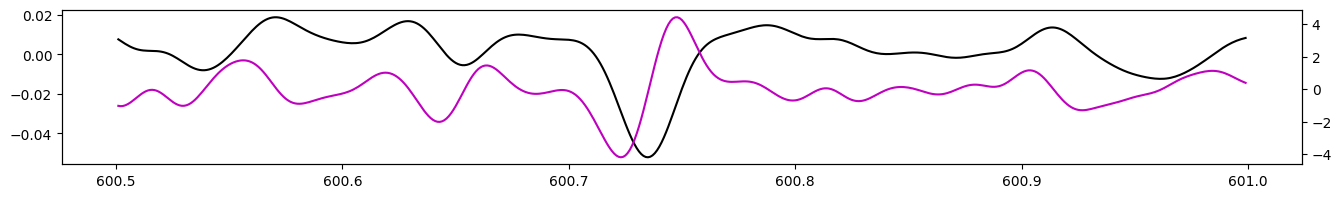

In [ ]:
# sharp_slope = np.diff(sharp_wave_band,prepend=0)
# fig,ax=plt.subplots(1,1, figsize=(16,2))
# # ax.plot(time_1khz[t_condit], sharp_slope[t_condit],'r')
# axr=ax.twinx()
# ax.plot(time_1khz[t_condit], sharp_wave_band[t_condit],'k')
# z_slope = z_trans(sharp_slope)
# axr.plot(time_1khz[t_condit], z_slope[t_condit],'m')

[0, 4260, 4404, 12255, 24925, 29584, 29666, 33934, 42986, 43228, 49212, 52779, 55701, 64303, 68895, 70369, 74578, 80006, 99449, 116998, 117406, 119481, 123666, 125984, 153430, 159066, 159484, 163548, 168610, 182318, 185806, 195345, 207686, 213180, 226142, 239629, 240335, 243149, 244868, 255730, 258704, 263982, 264547, 275539, 275955, 276040, 276444, 277528, 278511, 281075, 281942, 282144, 283307, 284877, 285476, 291615, 296215, 303847, 304834, 306803, 307015, 312934, 313996, 315682, 316567, 316638, 317438, 326195, 326313, 328712, 328813, 331401, 331529, 349381, 351197, 352696, 353578, 353700, 356509, 356737, 358073, 358346, 358382, 362940, 363147, 363339, 366859, 367017, 368742, 369593, 371226, 371410, 371917, 372508, 374096, 376167, 381096, 387394, 387445, 387841, 391925, 394234, 394963, 395380, 395468, 395681, 395838, 397593, 400072, 402684, 404212, 404673, 407270, 407871, 407958, 408737, 408845, 409816, 409890, 410774, 412227, 414683, 414792, 418153, 419140, 420303, 421155, 422149, 

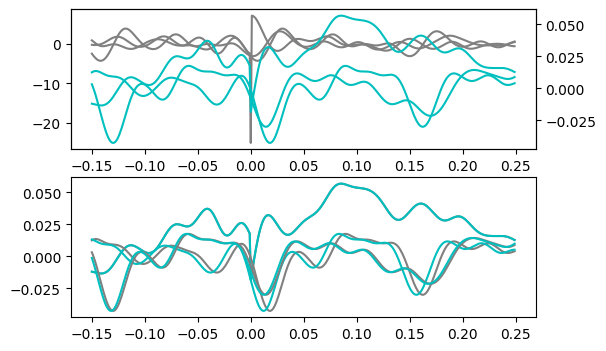

In [ ]:
### Trigger on max slope
mov_wind=15
trig_bool = z_slope<-3
trigs = np.where(np.diff(trig_bool,prepend=0)*1>.5)[0]
peak_window_s = np.array([-25,25])/1000
peak_window_tic = np.arange(peak_window_s[0]*fs,peak_window_s[1]*fs,1,dtype=int)
plot_window_s = np.array([-150,250])/1000
plot_window_tic = np.arange(plot_window_s[0]*fs,plot_window_s[1]*fs,1,dtype=int)
fig,ax=plt.subplots(2,1, figsize=(6,4))
ax0r = ax[0].twinx()

trigs_alligned = []
for t in trigs:

    sharp_wave_snip = z_slope[t+peak_window_tic]
    local_min_tic = np.where(sharp_wave_snip==np.min(sharp_wave_snip))[0][0]
    adjusted_t = t + local_min_tic+peak_window_tic[0]
    if t< 10000:
        ax[0].plot(plot_window_tic/fs,z_slope[t+plot_window_tic],'grey')
        ax0r.plot(plot_window_tic/fs,sharp_wave_band[t+plot_window_tic],'c')
        ax[1].plot(plot_window_tic/fs,sharp_wave_band[t+plot_window_tic],'grey')
        ax[1].plot(plot_window_tic/fs,sharp_wave_band[adjusted_t+plot_window_tic],'c')
    trigs_alligned.append(adjusted_t)
print(trigs_alligned)

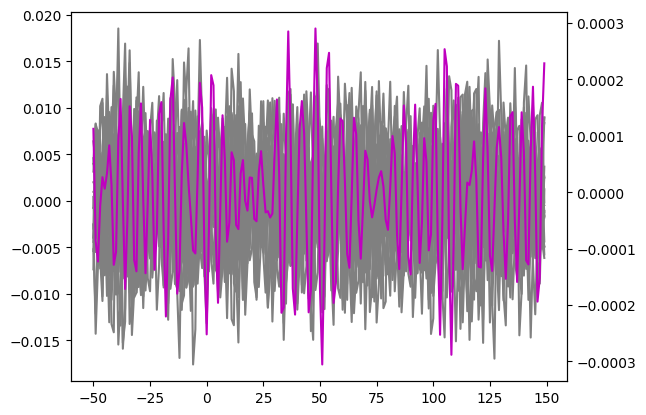

In [ ]:
rip_list = []

plot_window_s = np.array([-50,150])/1000
plot_window_tic = np.arange(plot_window_s[0]*fs,plot_window_s[1]*fs,1,dtype=int)


fig,ax=plt.subplots()
for t in trigs_alligned:
    rip_wave_snip = ripple_band[t+plot_window_tic]
    rip_list.append(rip_wave_snip)
    if t< 100000:
        ax.plot(plot_window_tic/fs*1000,rip_wave_snip,'grey')

rip_list = np.stack(rip_list)
rip_list.shape
axr=ax.twinx()
axr.plot(plot_window_tic/fs*1000,np.mean(rip_list,axis=0),'m')

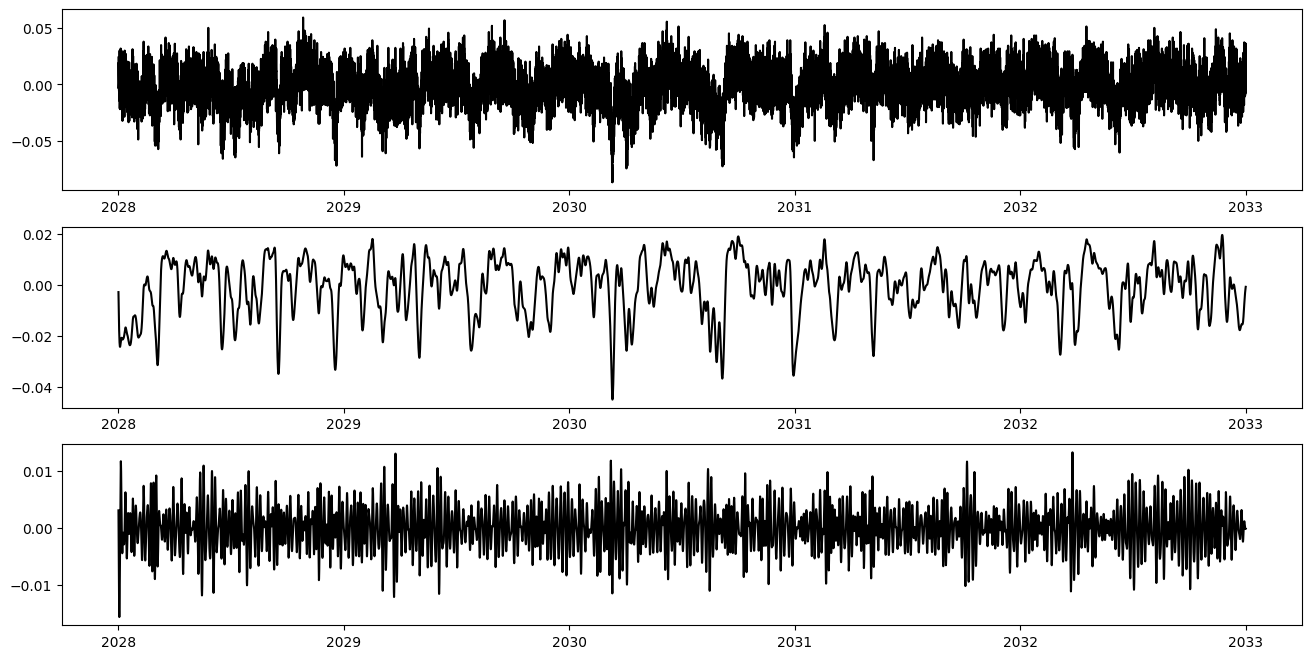

In [ ]:


fig,ax=plt.subplots(3,1, figsize=(16,8))
ax=ax.flatten()

t_condit = np.logical_and(time>2028,time<2033)
sub_y = v_trace[t_condit]
sub_x = time[t_condit]


b, a = scipy.signal.butter(2, [4,100], btype='bandpass',fs=10000)
gamma_band = scipy.signal.filtfilt(b, a, sub_y)
b, a = scipy.signal.butter(4, [100,200], btype='bandpass',fs=10000)
ripple_band = scipy.signal.filtfilt(b, a, sub_y)

ax[0].plot(sub_x,sub_y,'k')
ax[1].plot(sub_x,gamma_band,'k')
ax[2].plot(sub_x,ripple_band,'k')
# for a in ax: a.set_xlim([5.8,8.1])

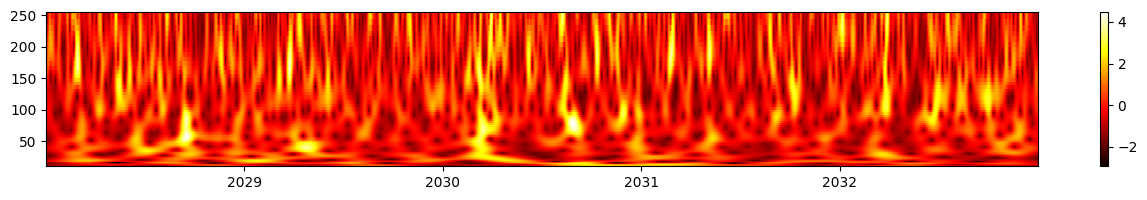

In [ ]:

fs = 10000
w = 6.
top_freq = fs/2
top_freq = 250
freq = np.logspace(np.log2(10), np.log2(top_freq), num=80, endpoint=True, base=2)
widths = w*fs / (2*freq*np.pi)
cwtm = scipy.signal.cwt(sub_y, scipy.signal.morlet2, widths, w=w)

cw_abs = np.abs(cwtm)
cw_mean = np.expand_dims(np.mean(cw_abs,axis=1),-1)
cw_std = np.expand_dims(np.std(cw_abs,axis=1),-1)
cw_z = (cw_abs - cw_mean) / cw_std

fig,ax=plt.subplots(1,1, figsize=(16,2))
cb= ax.pcolormesh(sub_x,freq,cw_z,cmap='hot')
fig.colorbar(cb,ax=ax)



In [ ]:
# from scipy import signal





fs = 10000
w = 6.
top_freq = fs/2
top_freq = 600
freq = np.linspace(1, top_freq, 100)
freq = np.logspace(np.log2(10), np.log2(top_freq), num=40, endpoint=True, base=2)
widths = w*fs / (2*freq*np.pi)
cwtm = scipy.signal.cwt(in0, scipy.signal.morlet2, widths, w=w)

cw_abs = np.abs(cwtm)
cw_mean = np.expand_dims(np.mean(cw_abs,axis=1),-1)
cw_std = np.expand_dims(np.std(cw_abs,axis=1),-1)
cw_z = (cw_abs - cw_mean) / cw_std





NameError: ignored

In [ ]:
b, a = scipy.signal.butter(2, [4,120], btype='bandpass',fs=10000)
gamma_band = scipy.signal.filtfilt(b, a, in0)
gamma_band_z = z_trans(gamma_band)
trig = np.diff(gamma_band_z<-3,prepend=0)==1

b, a = scipy.signal.butter(4, [130,180], btype='bandpass',fs=10000)
ripple_band = scipy.signal.filtfilt(b, a, in0-gamma_band)
ripple_band_z= z_trans(ripple_band)

trig_ind = np.where(trig)[0]

wave_list = []
trig_ind_peaks = []
for t in trig_ind:
    try:
        prepend_g = 1500
        append_g = 1500
        sub_x = np.arange(t-prepend_g,t+append_g)
        sub_y = gamma_band[sub_x]
        min_ind = np.where(sub_y==np.min(sub_y))[0][0]
        t_adj=t+(min_ind-prepend_g)
        sub_x = np.arange(t_adj-prepend_g,t_adj+append_g)
        sub_y = gamma_band[sub_x]
        wave_list.append(sub_y)
        trig_ind_peaks.append(t_adj)
    except: None

rip_list = []
for t in trig_ind_peaks:
    try:
        prepend_r = 500
        append_r = 500
        t=t
        sub_x = np.arange(t-prepend_r,t+append_r)
        sub_y = ripple_band[sub_x]
        rip_list.append(sub_y)
    except: None

window_t_g = np.arange(-prepend_g,append_g)/10000*1000
window_t_r = np.arange(-prepend_r,append_r)/10000*1000

rips = np.stack(rip_list)
waves = np.stack(wave_list)
fig,ax=plt.subplots(1,4,figsize=[12,4],gridspec_kw={'width_ratios':[30,30,30,1]})
ax=ax.flatten()
ax[0].plot(window_t_g, waves.T*1000,color='grey',zorder=-1)
ax[0].plot(window_t_g, np.mean(waves,axis=0)*1000,'r',zorder=999)
ax[1].plot(window_t_r,rips.T*1000,color='grey')
ax[1].plot(window_t_r,np.mean(rips,axis=0)*1000,'r',zorder=999)



cw_list = []
prepend_g = 1500
append_g = 1500
for t in trig_ind_peaks:
    try:
        sub_x = np.arange(t-prepend_g,t+append_g)
        cw_list.append(cw_z[:,sub_x])
    except: None

cw_stack = np.stack(cw_list,axis=-1)
cw_mean = np.mean(cw_stack,-1)
cb= ax[2].pcolormesh(window_t_g,freq,cw_mean,cmap='hot')
fig.colorbar(cb,cax=ax[3])
num_SWs = len(trig_ind_peaks)
rate = round(num_SWs/len(in0)*10000,2)

ax[0].set_title('Sharp_Waves (n=' + str(num_SWs)+'; '+str(rate)+'/s)')
ax[0].set_ylabel('LFP (uV)')
ax[1].set_title('SW triggered Ripple_Band')
ax[1].set_ylabel('LFP (uV)')
ax[2].set_title('SW triggered WaveletSpectrogram')
ax[2].set_ylabel('Freq (Hz)')
ax[3].set_ylabel('z_power')
for a in ax[:-1]:
    a.set_xlabel('time (ms)')

plt.tight_layout()